In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns 
import datetime as dt

from data_extraction import *
from sklearn import linear_model

/tmp/ipykernel_8638/1176516844.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Requesting Token...



/home/murali/anaconda3/envs/strava/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.strava.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [2]:
df = get_cleaned_dataset()

You are requesting page 1 of your activities data ...
You are requesting page 2 of your activities data ...


In [3]:
distance_in_miles = list(map(meters_to_miles, df["distance"].tolist()))
df["distance"] = distance_in_miles

In [4]:
sec_to_min = lambda s: s/60
time_in_min = list(map(sec_to_min, df["moving_time"]))
avg_pace = [time / dist for time, dist in zip(time_in_min, distance_in_miles)]
df["average_pace"] = avg_pace 

In [5]:
df.columns


Index(['resource_state', 'name', 'distance', 'moving_time', 'elapsed_time',
       'total_elevation_gain', 'type', 'sport_type', 'workout_type', 'id',
       'start_date', 'start_date_local', 'timezone', 'utc_offset',
       'location_city', 'location_state', 'location_country',
       'achievement_count', 'kudos_count', 'comment_count', 'athlete_count',
       'photo_count', 'trainer', 'commute', 'manual', 'private', 'visibility',
       'flagged', 'gear_id', 'start_latlng', 'end_latlng', 'average_speed',
       'max_speed', 'has_heartrate', 'heartrate_opt_out',
       'display_hide_heartrate_option', 'elev_high', 'elev_low', 'upload_id',
       'upload_id_str', 'external_id', 'from_accepted_tag', 'pr_count',
       'total_photo_count', 'has_kudoed', 'athlete.id',
       'athlete.resource_state', 'map.id', 'map.summary_polyline',
       'map.resource_state', 'suffer_score', 'average_pace'],
      dtype='object')

In [6]:
x = [dt.datetime.strptime(d[:10], '%Y-%m-%d').date() for d in df["start_date_local"]]

In [7]:
# Fall 23 average trend 

start_index_f = 6
end_index_f = 31

fall_2023_pace = df["average_pace"].tolist()[::-1][start_index_f:end_index_f]
start_date = x[::-1][start_index_f]
days_count_list = [(date - start_date).days for date in x[::-1][start_index_f:end_index_f]]

reg = linear_model.LinearRegression()
y_train = np.array(fall_2023_pace)
X_train = np.array(days_count_list)
reg.fit(X_train.reshape(-1, 1), y_train)

pred_pace = reg.predict(X_train.reshape(-1, 1))

In [8]:
# Spring 24 average trend 

start_index_s = 31
end_index_s = len(x)

fall_2023_pace = df["average_pace"].tolist()[::-1][start_index_s:end_index_s]
start_date = x[::-1][start_index_s]
days_count_list = [(date - start_date).days for date in x[::-1][start_index_s:end_index_s]]

reg = linear_model.LinearRegression()
y_train = np.array(fall_2023_pace)
X_train = np.array(days_count_list)
reg.fit(X_train.reshape(-1, 1), y_train)

pred_pace_s = reg.predict(X_train.reshape(-1, 1))

In [9]:
list_of_gears = df["gear_id"].unique().tolist()
color_choices = ['green', 'violet', 'r', 'orange']

color_list = [color_choices[list_of_gears.index(id)] for id in df["gear_id"]]

scale_list = (df["distance"]*30).tolist()

In [10]:
# get gear information
gear_info_dict = get_gear_info(list_of_gears[:-1])
shoe_names_list = [gear_info_dict[id]['name'] for id in gear_info_dict]

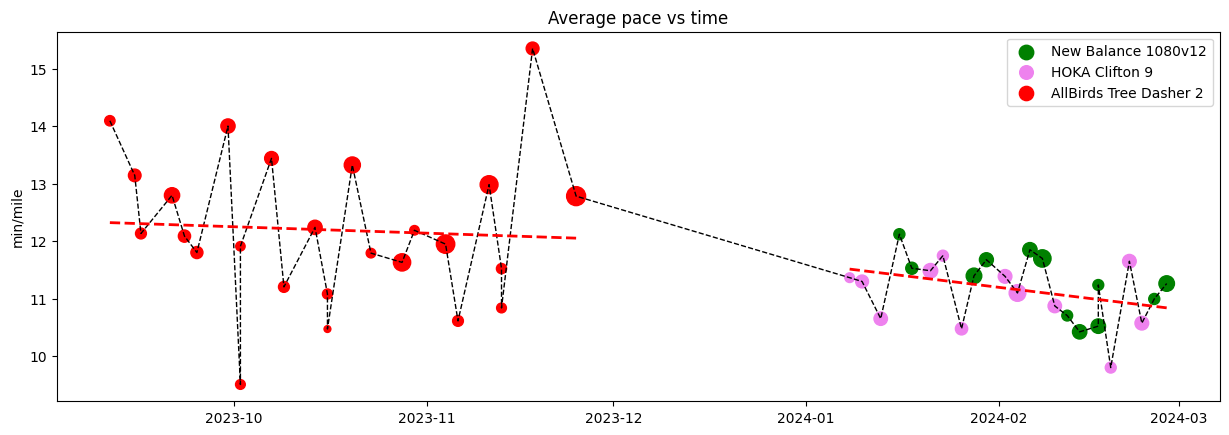

In [17]:
fig, axs = plt.subplots(1) 
fig.set_figwidth(15)

start_index = 6
axs.plot(x[::-1][start_index:], df["average_pace"].tolist()[::-1][start_index:], linestyle="--", linewidth=1.0, c='k')
for i, id in enumerate(list_of_gears[:-1]):
    x_data = [x[::-1][start_index:][j] for j in range(len(x[::-1][start_index:])) if df["gear_id"].tolist()[::-1][start_index:][j] == id]
    y_data = [df["average_pace"].tolist()[::-1][start_index:][j] for j in range(len(x[::-1][start_index:])) if df["gear_id"].tolist()[::-1][start_index:][j] == id]
    s_data = [scale_list[::-1][start_index:][j] for j in range(len(x[::-1][start_index:])) if df["gear_id"].tolist()[::-1][start_index:][j] == id]
    axs.scatter(x_data, y_data, s=s_data, marker='o', c=color_choices[i], label="{}".format(gear_info_dict[id]["name"]))
axs.plot(x[::-1][start_index_f:end_index_f], pred_pace, c='red', linestyle='--', linewidth='2')
axs.plot(x[::-1][start_index_s:end_index_s], pred_pace_s, c='red', linestyle='--', linewidth='2')

_ = axs.set_ylabel("min/mile")
_ = axs.set_title("Average pace vs time")
_ = plt.legend()

In [19]:
mean_per_shoe = dict()
std_per_shoe = dict()

for id in list_of_gears[:-1]:
    av_pace_per_shoe = [df["average_pace"].tolist()[j] for j in range(len(df)) if df["gear_id"].tolist()[j] == id]
    mean_per_shoe[id] = np.mean(av_pace_per_shoe)
    std_per_shoe[id] = np.std(av_pace_per_shoe)

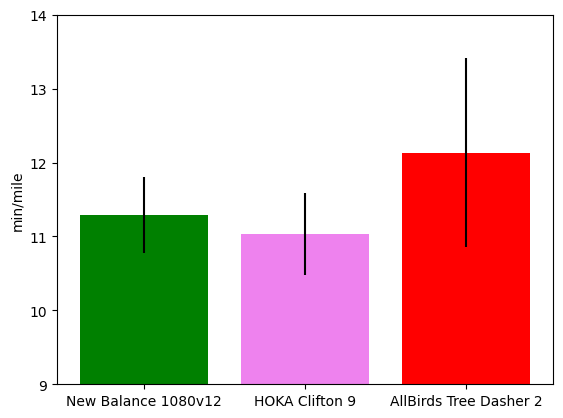

In [33]:
fig, axs = plt.subplots(1)

axs.bar([1, 2, 3], mean_per_shoe.values(), yerr=std_per_shoe.values(), color=color_choices)
axs.set_xticks([1, 2, 3])
axs.set_ybound([9,14])
_ = axs.set_xticklabels(shoe_names_list)
_ = axs.set_ylabel("min/mile")